# Monophonic pitch estimation 

### George Tzanetakis, University of Victoria 

In this notebook we will explore different ways of extracting pitch from monophonic audio 
signals. One synthetic melody example as well as an actual audio recording will be used 
to illustrate the different approaches. 


In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.interpolate import interp1d 
import IPython.display as ipd

First let's create a synthetic simple melody using a sinusoid generation function. 

In [2]:
srate = 22050.0

# generate a discrete time sinusoid signal with a specified amplitude, frequency, duration, and phase 
def sinusoid(freq=440.0, dur=1.0, srate=44100.0, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

# frequencies of three notes (C, D, E) 
c_freq = 523.0   
d_freq = 587.0  
e_freq = 659.0 

# generate sine signals corresponding to each note 
c_data = sinusoid(c_freq, 0.5, srate)
d_data = sinusoid(d_freq, 0.5, srate)
e_data = sinusoid(e_freq, 0.5, srate)

# form a simple melody by concateneting the signal arrays for each note 
melody1 = np.hstack([c_data, d_data, e_data, c_data, c_data, d_data, e_data, c_data])
ipd.Audio(melody1,rate=srate)

Let's also load an audio recording

In [3]:
import scipy.io.wavfile as wav
srate, audio_signal = wav.read("amazing_grace_female.wav")
# scale to -1.0/1.0 
melody2 = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
melody2 = (0.9 / max(melody2)) * melody2

plt.figure() 
plt.plot(melody2)
ipd.Audio(melody2,rate=srate)


We will be doing the processing in short chunks of the audio signal. This chunking process is common 
in many digital signal processing algorithms and is characterized by two numbers: the hop size in samples which is the number of samples we advance the start of the chunk in each iteration, and the window size which is the number of samples each chunk (window) will contain. First let's look at a particular chunk (typically called 
a window or a frame) for each input signal (the synthetic sinusoidal melody and the audio recording of Amazing Grace).  

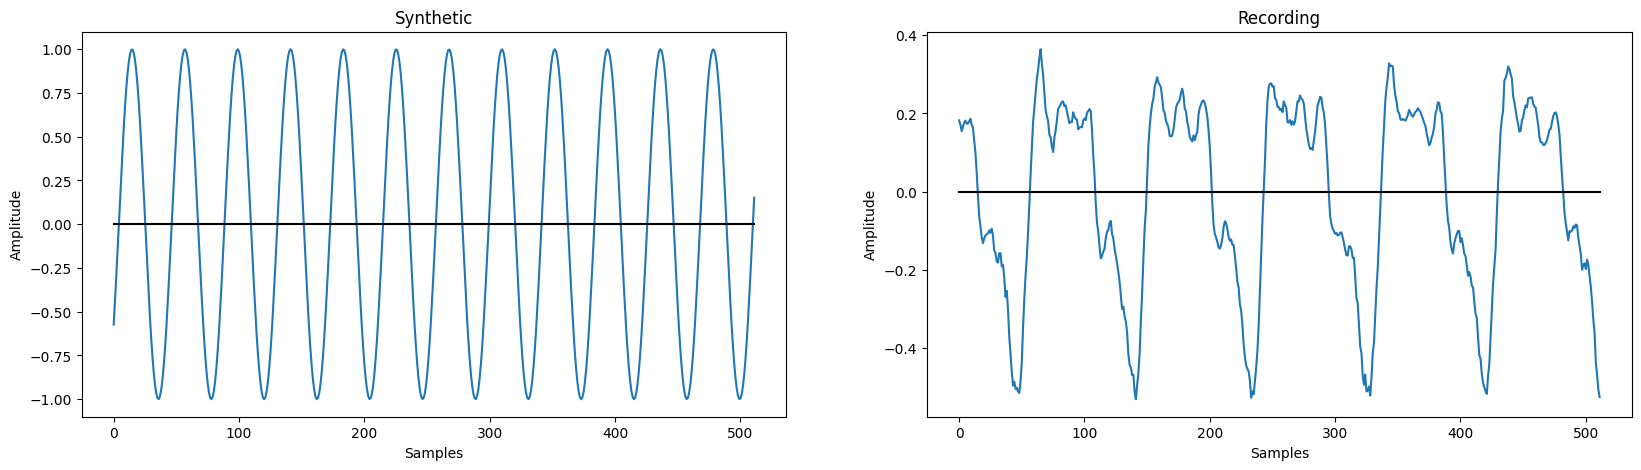

In [4]:
hopSize = 256
winSize = 512

# let's plot the 40th window 
o = 40 * hopSize 
frame1 = melody1[o:o+winSize]
frame2 = melody2[o:o+winSize ]

plt.figure(figsize=(20,5)) 
plt.subplot(121)
plt.title('Synthetic')
plt.plot(frame1)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(np.zeros(len(frame1)), color='black')

plt.subplot(122)
plt.title('Recording')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(frame2)
plt.plot(np.zeros(len(frame2)), color='black')

Let's look at a plot visualizing the short-time processing where the signal is processed in 
overlapping chunks of size window size and advancing by hop size. 

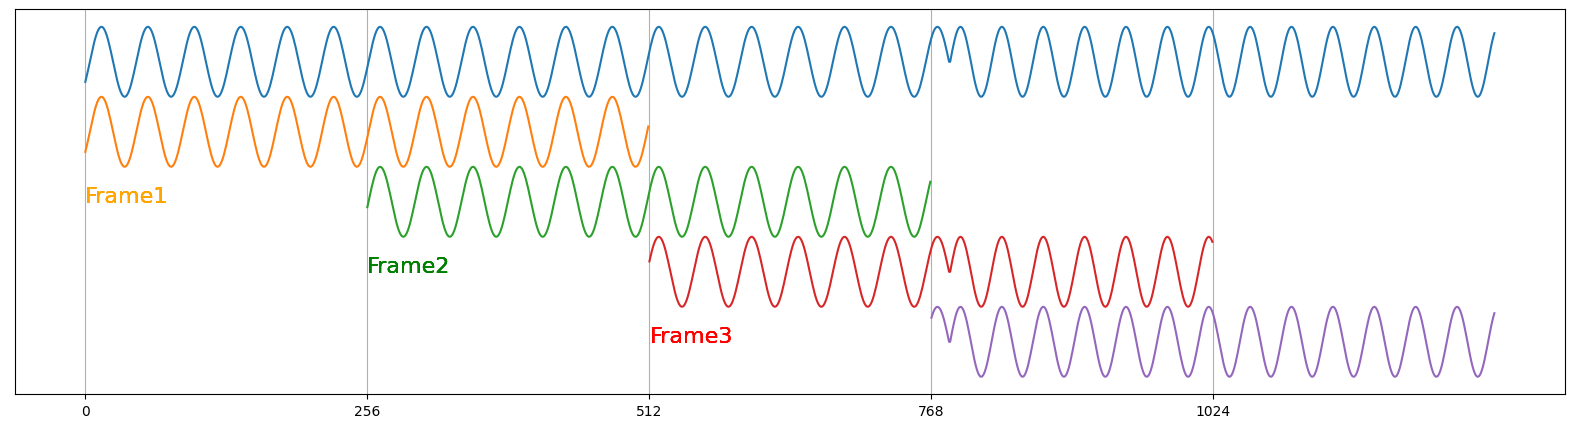

In [5]:
def plot_short_time(signal, hopSize, winSize, start_frame, dur_frames): 
    s  = start_frame
    long_chunk = signal[start_frame * hopSize: (start_frame+ dur_frames) * hopSize]

    plt.figure(figsize=(20,5)) 
    plt.plot(long_chunk)
    
    for m in np.arange(0,4): 
        start = m * hopSize 
        end = m * hopSize + winSize 
        frame = long_chunk[start:end]
        plt.plot(np.arange(start, end), frame - (m+1)* 2.0)
        plt.xticks(np.arange(0, len(long_chunk), step=hopSize))
        plt.text(0, -4, 'Frame1', fontsize=16, color='orange')
        plt.text(hopSize, -6, 'Frame2', fontsize=16, color='green')
        plt.text(2*hopSize, -8, 'Frame3', fontsize=16, color='red')


        plt.yticks([])
        plt.grid(True)

# plot a chunk of the synthetic input as well as the audio recording 
plot_short_time(melody1, 256, 512, 40, 5)
plot_short_time(melody2, 256, 512, 40, 5)

# change the hop size and window size 
plot_short_time(melody1, 128, 256, 40, 5)

Let's look at the zerocrossings for a particular frame and use them to estimate the pitch in Hz for 
that frame. 

Indices: [ 11  53  95 138 180 222 264 306 348 390 433 475]
Indices diffs: [42 42 43 42 42 42 42 42 42 43 42]
Mean diff: 42.181818
Pitch estimate in Hz: 522.737069


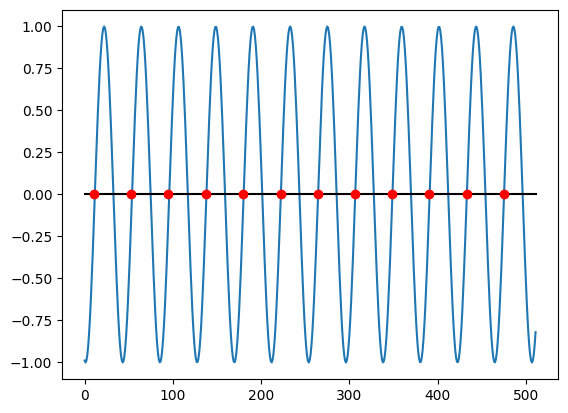

In [6]:
o = 10 * hopSize  
frame = melody1[o:o+winSize] 
zero_line = np.zeros(len(frame))

plt.figure() 
plt.plot(frame)
plt.plot(zero_line, color='black')

# find locations of zerocrossings 
indices = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]

# plot them 
plt.plot(indices, zero_line[indices], 'o', color='red')
print("Indices: %s" % np.array2string(indices))

# calculate the difference between successive elements 
print("Indices diffs: %s" % np.array2string(np.diff(indices)))
# take the mean difference - that's the period in samples 
print("Mean diff: %f" % np.mean(np.diff(indices)))
# now compute the pitch estimate 
print("Pitch estimate in Hz: %f" % (srate / np.mean(np.diff(indices))))

Now let's look at doing pitch estimation in the frequency domain by 
examining the magnitude of the Discrete Fourier Transform (DFT) of the frame. 
First we compute the location in frequency bins of the maximum magnitude value 
and then convert that value from frequency bin to frequency in Hz. 

Frequency bin of magnitude peak: 12.000000
Pitch estimate using DFT: 516.796875


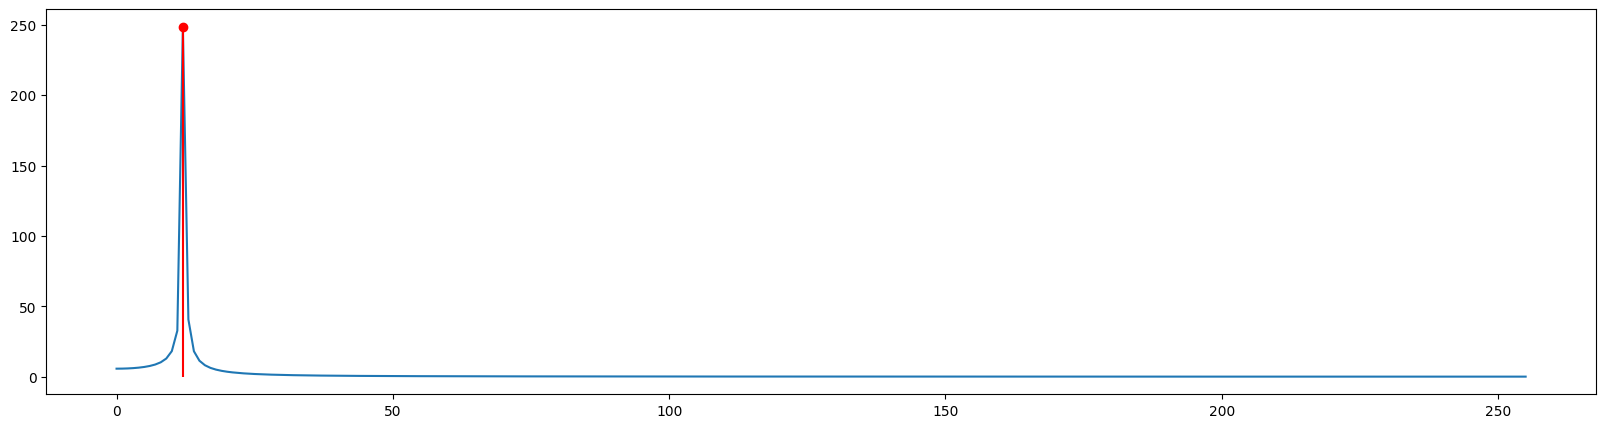

In [7]:
mag = np.abs(np.fft.fft(frame))
mag = mag[0:int(len(mag)/2)]
plt.figure(figsize=(20,5))
plt.plot(mag)
plt.stem([np.argmax(mag)], [np.max(mag)], linefmt='red')
print("Frequency bin of magnitude peak: %f" % np.argmax(mag))
print("Pitch estimate using DFT: %f" % (np.argmax(mag) * (srate / len(frame))))


Now that we have seen how we can estimate the pitch of a single frame of audio 
we can abstract this process into functions and then write a function that 
given an audio signal returns the associated pitch track and amplitude track (RMS) 
using a particular pitch extraction method. 

In [8]:
def pitch_zcrs(frame, srate): 
    indices = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]
    pitch_estimate = (srate / np.mean(np.diff(indices)))
    return pitch_estimate 

def pitch_fft(frame, srate): 
    mag = np.abs(np.fft.fft(frame))
    mag = mag[0:int(len(mag)/2)]
    pitch_estimate = np.argmax(mag) * (srate / len(frame))
    return pitch_estimate

def pitch_acr(frame, srate):
    acr = np.correlate(frame, frame, mode='full')
    acr = acr[int(len(acr)/2):]
    low_lag = np.argmin(acr)
    max_lag = np.argmax(acr[low_lag:])
    pitch_estimate = srate/float(low_lag + max_lag)
    return pitch_estimate

def pitch_amdf(frame, srate):
    N = len(frame)
    AMDF = np.zeros(N)
    for n in range(1,N):
        AMDF[n] = np.sum( np.abs(frame - np.concatenate( ( np.zeros(n), frame[:-n] ) ) ) )
    max_lag = np.argmax(AMDF)
    pitch_estimate = srate / float(np.argmin(AMDF[max_lag:]) + max_lag)
    return pitch_estimate 

def pitch_track(signal, hopSize, winSize, extractor): 
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

        if (pitch_track[m] > 1500): 
            pitch_track[m] = 0 
        
    return (amp_track, pitch_track)

## Check that AMDF function works properly ##

Check that your AMDF function works correctly using as input a sinusoidal signal with a frequency of 440Hz and checking the output of your function.

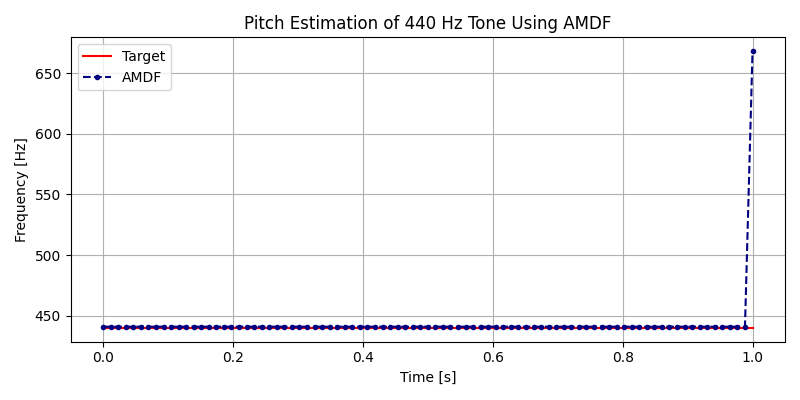

In [10]:
%matplotlib widget
test_freq = 440
test_tone = np.sin(2 * np.pi * test_freq / srate * np.arange(srate)) # 1 second of 440 Hz tone
_, pitch_test = pitch_track(test_tone, 256, 512, pitch_amdf)
t_axis = np.linspace(0, len(test_tone)/srate, len(pitch_test))
plt.figure(figsize=(8,4))
plt.title("Pitch Estimation of 440 Hz Tone Using AMDF")
plt.step(t_axis, np.ones_like(t_axis)*test_freq, color='red', label='Target')
plt.plot(t_axis, pitch_test, label='AMDF', color='navy', linestyle='--', marker='.')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

It works well until the last window, probably the last window is too small and the discountinuity error heavily alters the result.

## Process the recording of Amazing Grace and plot and sonify the resulting pitch contour ##

Based on the provided notebook, process the recording of Amazing Grace and plot and sonify the resulting pitch contour. Contrast it with the one based on zero-crossings and the one based on the magnitude spectrogram

In [15]:
# A smaller window and hope size leads to better results for these melodies
# compute the pitch tracks 
(at1, pt1_zcr) = pitch_track(melody1, 256, 512, pitch_zcrs)
(_, pt1_fft) = pitch_track(melody1, 256, 512, pitch_fft)
(_, pt1_acr) = pitch_track(melody1, 256, 512, pitch_acr)
(_, pt1_amd) = pitch_track(melody1, 256, 512, pitch_amdf)

(at2, pt2_zcr) = pitch_track(melody2, 256, 512, pitch_zcrs)
(_, pt2_fft) = pitch_track(melody2, 256, 512, pitch_fft)
(_, pt2_acr) = pitch_track(melody2, 256, 512, pitch_acr)
(_, pt2_amd) = pitch_track(melody2, 256, 512, pitch_amdf)

# applying median filtering to smooth the pitch tracks 
spt1_zcr = signal.medfilt(pt1_zcr, kernel_size=7)
spt1_fft = signal.medfilt(pt1_fft, kernel_size=7) 
spt1_acr = signal.medfilt(pt1_acr, kernel_size=7) 
spt1_amd = signal.medfilt(pt1_amd, kernel_size=7) 

spt2_zcr = signal.medfilt(pt2_zcr, kernel_size=7)
spt2_fft = signal.medfilt(pt2_fft, kernel_size=7) 
spt2_acr = signal.medfilt(pt2_acr, kernel_size=7) 
spt2_amd = signal.medfilt(pt2_amd, kernel_size=7) 

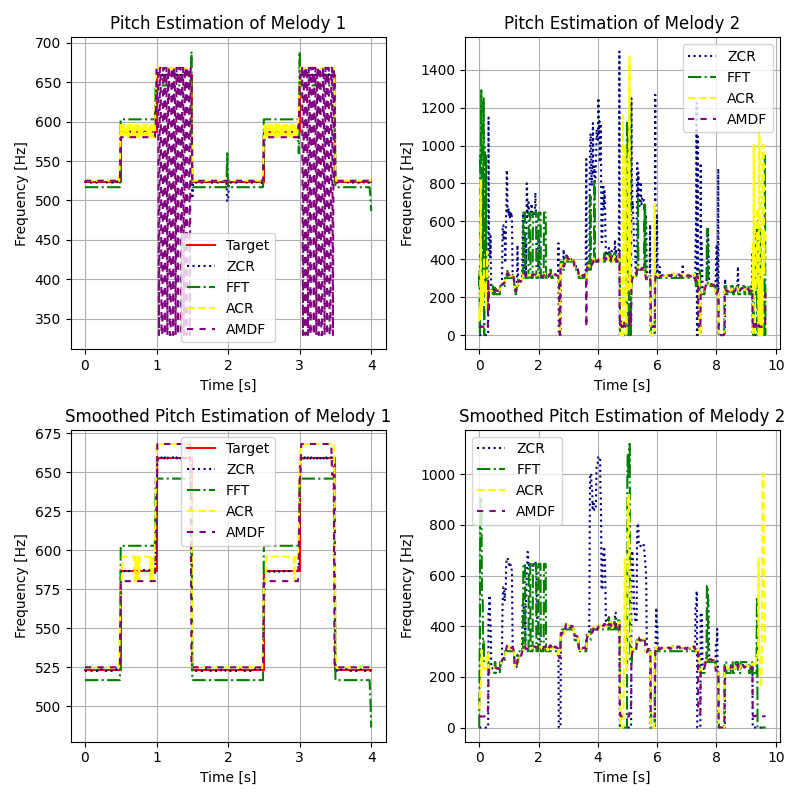

In [16]:
t_axis1 = np.linspace(0, len(melody1)/srate, len(pt1_zcr))
t_axis2 = np.linspace(0, len(melody2)/srate, len(pt2_zcr))
melody1_freq = [c_freq, c_freq, d_freq, e_freq, c_freq, c_freq, d_freq, e_freq, c_freq]


plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title("Pitch Estimation of Melody 1")
plt.step(np.linspace(0, len(melody1)/srate, len(melody1_freq)), melody1_freq, label='Target', color='red')
plt.plot(t_axis1, pt1_zcr, label='ZCR', color='navy', linestyle='dotted')
plt.plot(t_axis1, pt1_fft, label='FFT', color='green', linestyle='dashdot')
plt.plot(t_axis1, pt1_acr, label='ACR', color='yellow', linestyle='dashed')
plt.plot(t_axis1, pt1_amd, label='AMDF', color='purple', linestyle=(0, (3, 3)))
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.grid()
plt.legend()
plt.subplot(2,2,2)
plt.title("Pitch Estimation of Melody 2")
plt.plot(t_axis2, pt2_zcr, label='ZCR', color='navy', linestyle='dotted')
plt.plot(t_axis2, pt2_fft, label='FFT', color='green', linestyle='dashdot')
plt.plot(t_axis2, pt2_acr, label='ACR', color='yellow', linestyle='dashed')
plt.plot(t_axis2, pt2_amd, label='AMDF', color='purple', linestyle=(0, (3, 3)))
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.grid()
plt.legend()
plt.subplot(2,2,3)
plt.title("Smoothed Pitch Estimation of Melody 1")
plt.step(np.linspace(0, len(melody1)/srate, len(melody1_freq)), melody1_freq, label='Target', color='red')
plt.plot(t_axis1, spt1_zcr, label='ZCR', color='navy', linestyle='dotted')
plt.plot(t_axis1, spt1_fft, label='FFT', color='green', linestyle='dashdot')
plt.plot(t_axis1, spt1_acr, label='ACR', color='yellow', linestyle='dashed')
plt.plot(t_axis1, spt1_amd, label='AMDF', color='purple', linestyle=(0, (3, 3)))
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.grid()
plt.legend()
plt.subplot(2,2,4)
plt.title("Smoothed Pitch Estimation of Melody 2")
plt.plot(t_axis2, spt2_zcr, label='ZCR', color='navy', linestyle='dotted')
plt.plot(t_axis2, spt2_fft, label='FFT', color='green', linestyle='dashdot')
plt.plot(t_axis2, spt2_acr, label='ACR', color='yellow', linestyle='dashed')
plt.plot(t_axis2, spt2_amd, label='AMDF', color='purple', linestyle=(0, (3, 3)))
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

The plots provide us some visual indication that our pitch extraction 
process is doing something reasonable but it would be nice to be able 
to hear the generated pitch track. We can achieve this by using a 
sinusoid oscillator that changes instantaneous frequency and amplitude 
with every sample. The sonify function takes as input the amplitude 
and pitch track and return the resulting audio. 

In [17]:
def sonify(amp_track, pitch_track, srate, hop_size):

    times = np.arange(0.0, float(hop_size * len(pitch_track)) / srate,
                      float(hop_size) / srate)

    # sample locations in time (seconds)                                                      
    sample_times = np.linspace(0, np.max(times), int(np.max(times)*srate-1))

    # create linear interpolators for frequencies and amplitudes                              
    # so that we have a frequency and amplitude value for 
    # every sample 
    freq_interpolator = interp1d(times,pitch_track)
    amp_interpolator = interp1d(times,amp_track)

    # use the interpolators to calculate per sample frequency and                             
    # ampitude values                                                                         
    sample_freqs = freq_interpolator(sample_times)
    sample_amps  = amp_interpolator(sample_times)

    # create audio signal                                                                     
    audio = np.zeros(len(sample_times));
    T = 1.0 / srate
    phase = 0.0
    
    # update phase according to the sample frequencies 
    for i in range(1, len(audio)):
        audio[i] = sample_amps[i] * np.sin(phase)
        phase = phase + (2*np.pi*T*sample_freqs[i])

    return audio


## Sonify of Melody 1 ##

No quantization, no smoothing, zero-crossing is the best sounding one.

In [18]:
pt1_zcr_audio = sonify(at1, pt1_zcr, srate, hopSize)
ipd.Audio(pt1_zcr_audio,rate=srate)

In [19]:
pt1_fft_audio = sonify(at1, pt1_fft, srate, hopSize)
ipd.Audio(pt1_fft_audio,rate=srate)

In [20]:
pt1_acr_audio = sonify(at1, pt1_acr, srate, hopSize)
ipd.Audio(pt1_acr_audio,rate=srate)

In [21]:
pt1_amdf_audio = sonify(at1, pt1_amd, srate, hopSize)
ipd.Audio(pt1_amdf_audio,rate=srate)

## Sonify Melody 2 ##

No quantization, no smoothing, both ACR and AMDF sound pretty good but ACR has some artifacts.

In [22]:
pt2_zcr_audio = sonify(at2, pt2_zcr, srate, hopSize)
ipd.Audio(pt2_zcr_audio,rate=srate)

In [23]:
pt2_fft_audio = sonify(at2, pt2_fft, srate, hopSize)
ipd.Audio(pt2_fft_audio,rate=srate)

In [24]:
pt2_acr_audio = sonify(at2, pt2_acr, srate, hopSize)
ipd.Audio(pt2_acr_audio,rate=srate)

In [25]:
pt2_amdf_audio = sonify(at2, pt2_amd, srate, hopSize)
ipd.Audio(pt2_amdf_audio,rate=srate)

## Comparison Table ##

Create a table comparing each monophonic pitch extraction algorithm you have available (zerocrossings, fft, andf) in terms of running time. Process 10 times the Amazing Grace recording and average the results to get a more accurate comparison.

In [26]:
# Import package for timing a process
import timeit
iterations = 10

In [27]:
# Declare needed functions for test
SETUP_STMT = '''
import numpy as np
import scipy.io.wavfile as wav

# Import audio for test
srate, audio_signal = wav.read("amazing_grace_female.wav")
# scale to -1.0/1.0 
melody2 = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
melody2 = (0.9 / max(melody2)) * melody2

# Declare pitch estimation algorithms
def pitch_zcrs(frame, srate): 
    indices = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]
    pitch_estimate = (srate / np.mean(np.diff(indices)))
    return pitch_estimate 

def pitch_fft(frame, srate): 
    mag = np.abs(np.fft.fft(frame))
    mag = mag[0:int(len(mag)/2)]
    pitch_estimate = np.argmax(mag) * (srate / len(frame))
    return pitch_estimate

def pitch_acr(frame, srate):
    acr = np.correlate(frame, frame, mode='full')
    acr = acr[int(len(acr)/2):]
    low_lag = np.argmin(acr)
    max_lag = np.argmax(acr[low_lag:])
    pitch_estimate = srate/float(low_lag + max_lag)
    return pitch_estimate

def pitch_amdf(frame, srate):
    N = len(frame)
    AMDF = np.zeros(N)
    for n in range(1,N):
        AMDF[n] = np.sum( np.abs(frame - np.concatenate( ( np.zeros(n), frame[:-n] ) ) ) )
    max_lag = np.argmax(AMDF)
    pitch_estimate = srate / float(np.argmin(AMDF[max_lag:]) + max_lag)
    return pitch_estimate 

def pitch_track(signal, hopSize, winSize, extractor): 
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

        if (pitch_track[m] > 1500): 
            pitch_track[m] = 0 
        
    return (amp_track, pitch_track)
'''

In [28]:
TEST_ZCR = '''
(at, pt_zcr) = pitch_track(melody2, 256, 512, pitch_zcrs)
'''
zcr_time = timeit.repeat(stmt=TEST_ZCR, setup=SETUP_STMT, number=1, repeat=iterations)

In [29]:
TEST_FFT = """
(at, pt_fft) = pitch_track(melody2, 256, 512, pitch_fft)
"""
fft_time = timeit.repeat(stmt=TEST_FFT, setup=SETUP_STMT, number=1, repeat=iterations)

In [30]:
TEST_ACR = """
(at, pt_acr) = pitch_track(melody2, 256, 512, pitch_acr)
"""
acr_time = timeit.repeat(stmt=TEST_ACR, setup=SETUP_STMT, number=1, repeat=iterations)

In [31]:
TEST_AMDF = """
(at, pt_amd) = pitch_track(melody2, 256, 512, pitch_amdf)
"""
amd_time = timeit.repeat(stmt=TEST_AMDF, setup=SETUP_STMT, number=1, repeat=iterations)

In [32]:
# Organize and average data
time_data = np.array([ zcr_time, fft_time, acr_time, amd_time ])
time_data = time_data.reshape((4,iterations)).T
time_data_avg = np.mean(time_data, axis=0)
time_data_wavg = np.zeros((iterations+1, 4))
time_data_wavg[-1,:] = time_data_avg
time_data_wavg[0:-1,:] = time_data

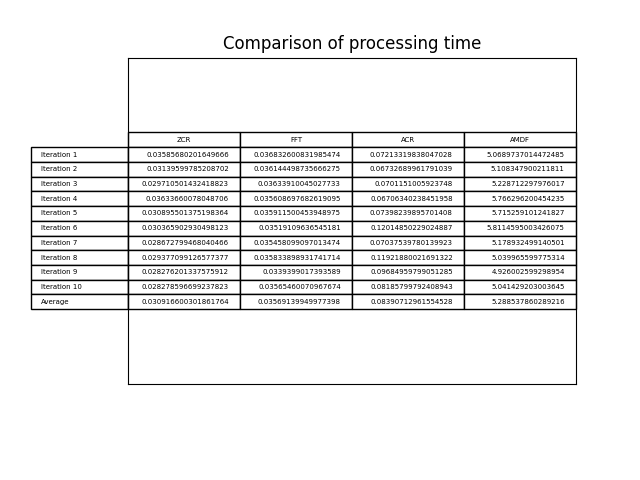

In [33]:
col_name = ['ZCR', 'FFT', 'ACR', 'AMDF']

row_name = []
for n in range(iterations):
    row_name.append('Iteration ' + str(n+1))
row_name.append('Average')


%matplotlib widget
plt.title('Comparison of processing time')
plt.table(cellText=time_data_wavg,
          colLabels=col_name,
          rowLabels=row_name,
          loc='center')
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)
#plt.ylabel(f"Loss in ${value_increment}'s")
#plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.yticks([])
plt.xticks([])
plt.show()

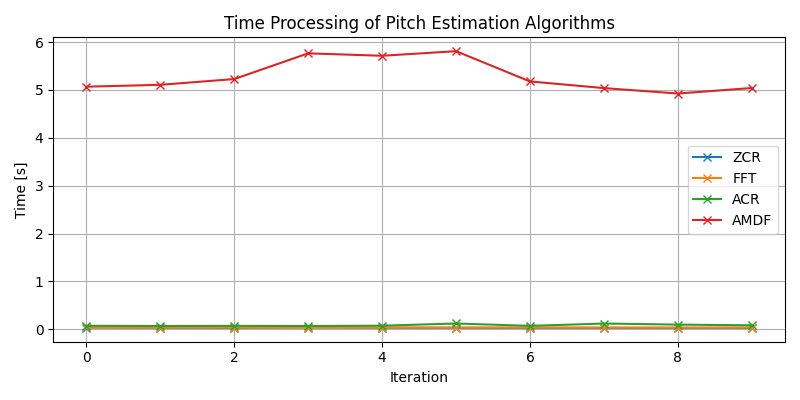

In [34]:
plt.figure(figsize=(8,4))
plt.title("Time Processing of Pitch Estimation Algorithms")
plt.plot(time_data, linestyle=None, marker='x')
plt.xlabel("Iteration")
plt.ylabel("Time [s]")
plt.grid()
plt.legend(col_name)
plt.tight_layout()
plt.show()

AMDF is much slower due to the python for loop, if I change everything to be done with numpy arrays to remove the for loop the code should run at a speed similar to the ACR. The best performer in terms of time is the FFT.

## Calculate the mean-squarred error ##

Select the pitch contour that you think sounds best. Calculate the mean-squarred error between the result of the two other pitch estimation algorithms using the pitch contour you think sounds best as the ground truth. Which of the two has the smallest error? Does this agree with your perception?

I thought AMDF was the best sounding so I'll use that one as the ground truth

In [35]:
mse_zcr = np.mean( (pt2_zcr - pt2_amd)**2 )
print("ZCR MSE: " + str(mse_zcr))


ZCR MSE: 42644.01066277711


In [36]:
mse_fft = np.mean( (pt2_fft - pt2_amd)**2 )
print("FFT MSE: " + str(mse_fft))

FFT MSE: 32759.090195758727


In [37]:
mse_acr = np.mean( (pt2_acr - pt2_amd)**2 )
print("ACR MSE: " + str(mse_acr))

ACR MSE: 29304.42731987524


ACR has the smallest error compared to the other three. This makes sense due to the ACR and AMDF being complementary in a way as the peaks of the ACR correspond to dips in the AMDF. The error is huge to the value being larger than 1 and then squared.